In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

### Dataset & DataLoader

In [3]:
# Image Dataset
training_data = datasets.MNIST(
    root='/media/ubuntu/dataset/',
    train=True,
    download=True,
    transform=ToTensor()
)

testing_data = datasets.MNIST(
    root='/media/ubuntu/dataset/',
    train=False,
    download=True,
    transform=ToTensor()
)

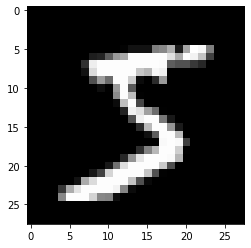

In [4]:
import matplotlib.pyplot as plt

img, label = training_data[0]
plt.imshow(img.squeeze().numpy(), cmap="gray")
plt.show()

In [5]:
# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, data_dir, labels, transform=None, target_transform=None) -> None:
        self.data = data_dir
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        """Return the number of samples in the custom dataset."""
        return len(self.labels)

    def __getitem__(self, idx):
        """Loda and return a data sample from the custom dataset at given index."""
        data = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(data)
        if self.target_transform:
            label = self.target_transform(label)
        return data, label

In [6]:
# We can load the train and test dataset into dataloaders 
# so that we can retrive data samples and interate through 
# the dataset in a batch/mini-batch manner. 
train_loader = DataLoader(training_data, batch_size=128, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=128, shuffle=True)

### Model

In [7]:
from torch import nn
import torch.nn.functional as F

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), stride=(1,1)),
            nn.BatchNorm2d(32),
            nn.ReLU(), 
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=(1,1)),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.dp1 = nn.Dropout2d(0.25)
        self.dp2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv(x)
        x = F.max_pool2d(x, 2)

        x = self.dp1(x)
        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp2(x)
        x = self.fc2(x)
        return x 

### Trainval

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def build_model(nn):
    model = nn
    model.to(torch.device(device))

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    return model, criterion, optimizer


def train(loader, model, criterion, optimizer):
    model.train()
    training_loss = 0.0
    for idx, data in enumerate(loader):
        optimizer.zero_grad()    # Clear gradients

        x = data[0].to(torch.device(device))
        y = data[1].to(torch.device(device))
        
        logits = model(x)             # Feedforward
        loss = criterion(logits, y)   # Compute gradients

        loss.backward()          # Backward pass
        optimizer.step()         # Update model parametersss

        training_loss += loss.item()
    return training_loss


@torch.no_grad()
def validation(loader, model, criterion):
    model.eval()
    for idx, data in enumerate(loader):
        x = data[0].to(torch.device(device))
        y = data[1].to(torch.device(device))

        logits = model(x)
        loss = criterion(logits, y)  


In [10]:
from torch.utils.tensorboard import SummaryWriter

EPOCH = 20
model, criterion, optimizer = build_model(CNN())
writer = SummaryWriter('experiment/mnist_cnn')
for epoch in range(1, EPOCH+1):
    # Training & Validation
    cumulative_loss = train(train_loader, model, criterion, optimizer)
    writer.add_scalar('training_loss at each epoch', 
                       cumulative_loss / len(train_loader), 
                       epoch)
    validation(test_loader, model, criterion)

### Image Semantic Segmentation (UNet)

In [11]:
from torchvision.transforms import Compose, Resize

# Cityscapes Dataset
training_data = datasets.Cityscapes(
    root='/media/ubuntu/dataset/cityscapes/',
    split='train',
    mode='fine',
    target_type='color',
    transform=Compose([ToTensor(), Resize((572, 572))]), 
    target_transform=Compose([ToTensor(), Resize((564, 564))])
)

testing_data = datasets.Cityscapes(
    root='/media/ubuntu/dataset/cityscapes/',
    split='test',
    mode='fine',
    target_type='color',
    transform=Compose([ToTensor(), Resize((572, 572))]), 
    target_transform=Compose([ToTensor(), Resize((564, 564))])
)

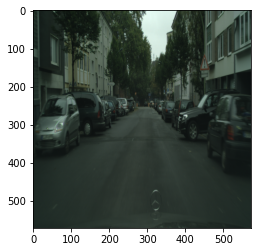

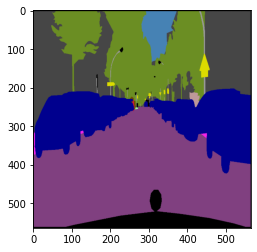

In [12]:
img, smnt = training_data[0]
plt.imshow(img.squeeze().permute(1, 2, 0).numpy())
plt.show()

plt.imshow(smnt.squeeze().permute(1, 2, 0).numpy())
plt.show()

In [13]:
train_loader = DataLoader(training_data, batch_size=3, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=3, shuffle=True)

In [14]:
import torchvision.transforms.functional as TF


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(3,3), stride=(1,1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=(3,3), stride=(1,1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=4, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1, stride=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        # reverse skip_connections
        skip_connections = skip_connections[::-1]

        # Ups = [up_conv_0, double_conv_0, up_conv_1, douple_conv_1, ...]
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        x = self.final_conv(x)
        return x

In [14]:
model, criterion, optimizer = build_model(UNET())
writer = SummaryWriter('experiment/semantic_unet')
for epoch in range(1, EPOCH+1):
    # Training & Validation
    cumulative_loss = train(train_loader, model, criterion, optimizer)
    writer.add_scalar('training_loss at each epoch', 
                       cumulative_loss / len(train_loader), 
                       epoch)
    validation(test_loader, model, criterion)

### Non-DL Computing (k Nearest Neighbor Clustering)

In [24]:
def pairwise_distance(x):
    """
    Compute pairwise distance of data.
    Args:
        x: tensor (num_points, num_dims)
    Returns:
        nn_idx: (num_points, knn_idx)
    """
    x_inner = -2*torch.matmul(x, x.transpose(1, 0))
    x_square = torch.sum(torch.mul(x, x), dim=-1, keepdim=True)
    return x_square + x_inner + x_square.transpose(1, 0)

class Torch_KNN(nn.Module):
    def __init__(self, k=9) -> None:
        super(Torch_KNN, self).__init__()
        self.k = k

    def forward(self, x):
        neg_adj = -pairwise_distance(x.detach())
        _, nn_idx = torch.topk(neg_adj, k=self.k)
        return nn_idx

In [35]:
rand_points = torch.rand(20000, 32)
rand_points = rand_points.to(torch.device(device))

knn = Torch_KNN(k=9)
knn.to(torch.device(device))

knn_ids = knn(rand_points)

In [36]:
knn_ids[0]

tensor([    0,  3313, 19538, 15550, 16390,  2294,  6171,  2224,  8378],
       device='cuda:0')

In [37]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=9, algorithm='brute').fit(rand_points.cpu().numpy())
_, indices = nbrs.kneighbors(rand_points.cpu().numpy())

In [38]:
indices[0]

array([    0,  3313, 19538, 15550, 16390,  2294,  6171,  2224,  8378])